In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import timeit

import pandas as pd
import geopy

# Scrape online data

## Data from BeerAdvocate

In [94]:
def parse_beer_page(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    name = soup.find('title').text.split('|')[0].strip()
    style = soup.find(title="Learn more about this style.").find('b').text
    alc_perc = float(soup.find_all(title="Percentage of alcohol by volume.")[-1].find('b').text[:-1])
    
    score_temp = soup.find(class_="ba-score Tooltip")
    if score_temp is not None:
        score = float(score_temp.text)
    else: score = np.NaN
    rating = float(soup.find(class_="ba-ravg Tooltip").text)
    brewery = soup.find(title="View more beers and info from this brewery.").text
    country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    
    return dict(name=name, style=style, alc_perc=alc_perc, 
                score=score, rating=rating, brewery=brewery, country=country)
    

In [165]:
def get_beer_country(url, session=requests):
    try:
        page = session.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
    except:
        country = ''
    return country

In [99]:
parse_beer_page('https://www.beeradvocate.com/beer/profile/2385/87878/')

{'name': 'Dark Ale',
 'style': 'American Brown Ale',
 'alc_perc': 4.0,
 'score': nan,
 'rating': 3.44,
 'brewery': 'Black Duck Brewery',
 'country': 'Australia'}

In [106]:
get_beer_country('https://www.beeradvocate.com/beer/profile/2/3/')

'United States'

In [109]:
countries = []
url = 'https://www.beeradvocate.com/beer/profile/2/{}/'
for i in range(100):
    try:
        countries.append(get_beer_country(url.format(i)))
    except:
        print(i)
    

1
2
22
25
53
57
60
64
70
77
91
98


In [167]:
s = requests.Session()
timeit.timeit(lambda: get_beer_country(url.format(15002),s), number=5)

3.777793766999821

In [146]:
timeit.timeit(lambda: requests.head(url.format(19)), number=1)

0.8501878259994555

In [147]:
requests.head(url.format(19))

<Response [301]>

In [149]:
1.5* 100000 / 3600

41.666666666666664

### Try to improve speed with parallel requests

In [160]:
import eventlet

urls = [url.format(i) for i in range(50)]
pool = eventlet.GreenPool(50)

countries = []
def pool_work():
    for country in pool.imap(get_beer_country, urls):
        countries.append(country)
        print('one is done')

timeit.timeit(pool_work, number=1)

one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done
one is done


60.20601609700043

In [154]:
urls

['https://www.beeradvocate.com/beer/profile/2/3/',
 'https://www.beeradvocate.com/beer/profile/2/4/',
 'https://www.beeradvocate.com/beer/profile/2/5/',
 'https://www.beeradvocate.com/beer/profile/2/6/',
 'https://www.beeradvocate.com/beer/profile/2/7/',
 'https://www.beeradvocate.com/beer/profile/2/8/',
 'https://www.beeradvocate.com/beer/profile/2/9/',
 'https://www.beeradvocate.com/beer/profile/2/10/',
 'https://www.beeradvocate.com/beer/profile/2/11/',
 'https://www.beeradvocate.com/beer/profile/2/12/',
 'https://www.beeradvocate.com/beer/profile/2/13/',
 'https://www.beeradvocate.com/beer/profile/2/14/',
 'https://www.beeradvocate.com/beer/profile/2/15/',
 'https://www.beeradvocate.com/beer/profile/2/16/',
 'https://www.beeradvocate.com/beer/profile/2/17/',
 'https://www.beeradvocate.com/beer/profile/2/18/',
 'https://www.beeradvocate.com/beer/profile/2/19/',
 'https://www.beeradvocate.com/beer/profile/2/20/',
 'https://www.beeradvocate.com/beer/profile/2/21/',
 'https://www.beera

In [169]:
from concurrent.futures import ThreadPoolExecutor
from requests_futures.sessions import FuturesSession

session = FuturesSession(max_workers=5)
cs = []
timeit.timeit(lambda: cs.append(get_beer_country(url.format(15002),session)), number=5)

0.007156055999985256

In [172]:
cs

['', '', '', '', '']

In [175]:
from concurrent.futures import as_completed
from requests_futures.sessions import FuturesSession

def get_beer_countries_parall(urls):
    countries = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            countries.append(country)
        except:
            pass
    
    return countries

In [187]:
def get_swiss_beers_parall(urls):
    swissbeers = []
    session = FuturesSession(max_workers=5)
    
    futures = [session.get(url) for url in urls]
    for future in as_completed(futures):
        try:
            resp = future.result()
            soup = BeautifulSoup(resp.content, 'html.parser')
            country = soup.find_all(href=lambda x: x and x.startswith('/place/directory/'))[-1].text
            if country == 'Switzerland':
                swissbeers.append(resp.url)
        except:
            pass
    
    return swissbeers

In [176]:
urls = [url.format(i) for i in range(50)]

timeit.timeit(lambda: get_beer_countries_parall(urls), number=1)

6.967507653000212

In [195]:
swiss_beers_urls_to12k = get_swiss_beers_parall([url.format(i) for i in range(12000)])

KeyboardInterrupt: 

### List all CH breweries from BeerAdvocate with login

In [298]:
base_url = 'https://www.beeradvocate.com'
def brewery_extract(row):
    cols = row.find_all('td')
    first_el = cols[0].find('a')
    link = base_url +first_el['href']
    brewery_name = first_el.text
    def treat_dash(text):
        if text=='-':
            return 'nan'
        else:
            return text
    ratings, nbeers = [treat_dash(x.text) for x in cols[-2:]]
    ratings = float(ratings)
    nbeers = int(nbeers)
    dic = dict(
        name = brewery_name, link = link,
        ratings = ratings, n_beers = nbeers
        )
    return dic
    

In [299]:
def treat_address(list_ad):
    ad = ''
    for el in list_ad:
        if el.name == 'br':
            ad += '\n'
        elif el.name == 'a':
            ad += el.get_text()
        else:
            ad += str(el).strip()
    ad = ad.split('\n\n')
    ad = list(map(lambda x: x.strip(), ad))
    if len(ad) == 2:
        address, tel = ad
    else:
        address = ad[0]
        tel = ''
    return dict(address=address, telephone=tel)

In [302]:
def breweries_from_page(page):
    table_rows = iter(page.find('table').find_all('tr'))
    breweries = []
    for row in table_rows:
        #columns = row.find_all('td')
        #table.append([el.text.rstrip() for el in columns])
        if row.find(href=lambda x: x and x.startswith('/beer/profile/')):
            brew_dic = brewery_extract(row)
            address_row = next(table_rows).find('td')
            list_ad = list(address_row.children)
            brew_dic.update(treat_address(list_ad))
            breweries.append(brew_dic)
    return breweries

In [303]:
s = requests.Session()
url_login = 'https://www.beeradvocate.com/community/login/login'

with open('ba_credentials','r') as f:
    login, password = f.read().splitlines() 
payload = {'login': login, 'password': password}
page = s.post(url_login, data=payload)

url_ch_gen = 'https://www.beeradvocate.com/place/list/?start={}&&c_id=CH&brewery=Y&sort=name'
start_n = 0
search = True
breweries_ch = []
while search:
    brew_page = BeautifulSoup(s.get(url_ch_gen.format(start_n)).content)
    more_breweries = brew_page.find_all(href=lambda x: x and x.startswith('/beer/profile/'))
    if len(more_breweries) >0 :
        breweries_ch += breweries_from_page(brew_page)
    else:
        search=False
    
    start_n += 20
    print(start_n)
    


20
40
60
80
100
120
140
160


In [304]:
breweries_ch_df = pd.DataFrame(breweries_ch)

In [305]:
breweries_ch_df

,name,link,ratings,n_beers,address,telephone
0,4655 Brewing Company,https://www.beeradvocate.com/beer/profile/41488/,NaN,4,"Stüsslingen, 4655\nSwitzerland",
1,523,https://www.beeradvocate.com/beer/profile/44206/,3.79,2,"Sonnenweg 30\nKöniz, 3098\nSwitzerland",+41 77 450 7655
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875
3,À tue-tête,https://www.beeradvocate.com/beer/profile/52843/,4.14,9,"Chemin de la Biole 10\nAigle, 1860\nSwitzerland",+41 79 235 56 49
4,Ahoi Bier,https://www.beeradvocate.com/beer/profile/42305/,3.67,4,"Schlieren, 8952,Switzerland",
...,...,...,...,...,...,...
135,Volta Bräu,https://www.beeradvocate.com/beer/profile/39036/,NaN,2,"Voltastrasse 30\nBasel, 4056\nSwitzerland",+41 61 690 91 29
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392
137,Wartauer Seegal Bräu,https://www.beeradvocate.com/beer/profile/39074/,NaN,8,"Hauptstrasse 33/35\nTrübbach, 9477\nSwitzerland",+41 78 878 19 52
138,Weedbeer,https://www.beeradvocate.com/beer/profile/32639/,3.00,1,"Chemin de l'Etraz 14\nOrbe, 1350\nSwitzerland",+41 21 312 68 21


## Attemps with Untappd

In [15]:
# test untapped
#cookies = {'uid': '232323', 'pass': '32323232323232323232323',
#           '__cfduid': '2323232323adasdasdasdas78d6asdasjdgawi8d67as'}
cookies = {'Name': 'untappd_user_v3_e', 
           'Value': 'cf983db65cd6570b3aa37c006adf1491321592df48ef861c4c75ad3c12a93d0c20890aba646fcc0d12a8102d34b655df916b54bee8927d0ed18daf7d1fac9880vdaSZ3BwBT8TUKJ14m29MMk8ztYNxJWrCsNgWTFrqXOjt0a6GddRjI2IPA3rXn0EbH0WlNXTT0WvdjeQjdFeZA%3D%3D',
           }
url_ut = 'https://untappd.com/w/brasserie-des-franches-montagnes-bfm/4719/beer'

#page_ut = requests.get(url_ut, cookies=cookies)
page_ut = requests.get(url_ut)
#soup_ut = BeautifulSoup(page_ut, 'lxml')

with open('test_untappd.html','bw') as f:
    f.write(page_ut.content)

In [20]:
#url_b = 'https://untappd.com/b/brasserie-des-franches-montagnes-bfm-225-saison/270389'
url_b = 'https://untappd.com/home'
page_ut = requests.get(url_b)

with open('test_untappd.html','bw') as f:
    f.write(page_ut.content)


In [21]:
page_ut.content

b'Too Many Requests'

## Scrape data from  RateBeer

### List of breweries 

In [126]:
# Grab list of breweries from RateBeer

url_ch_breweries = 'https://www.ratebeer.com/breweries/switzerland/0/191/'
page_rb_breweries = requests.get(url_ch_breweries)

soup_rb_breweries = BeautifulSoup(page_rb_breweries.content)

In [155]:
def treat_row_RB_breweries(row):
    base_url = 'https://www.ratebeer.com' 
    brew, place = row[0].find_all('a')

    place = place.text
    link = base_url +  brew['href']
    name = brew.text.strip()
    #row[0]
    brewer_type = row[1].text
    beer_count = int(row[2].text)
    established = int(row[4].text)
    brewer= dict(
        name=name, link=link,
        location=place, brewer_typ=brewer_type,
        beer_count=beer_count, established_year=established,
    )
    return brewer

In [194]:
for row in soup_rb_breweries.find('table').find_all('tr'):
    l = (len([el for el in row.children]))
    if l != 5:
        print(l)

In [199]:
breweries = []
for row in soup_rb_breweries.find('table').find_all('tr'):
    row_els = row.find_all('td')
    if len(row_els)>1:
        breweries.append(treat_row_RB_breweries(row_els))


In [202]:
breweries_ch_RB_df = pd.DataFrame(breweries)


### Grabbing more brewery information from RateBeer

In [172]:
from selenium import webdriver
import time

#my_url = breweries_ch_RB_df.loc[12,'link']
search_string = 'Ahoi'
my_url = breweries_ch_RB_df[breweries_ch_RB_df['name'].apply(lambda s: search_string in s)]['link'].values[0]


driver = webdriver.PhantomJS()
driver.set_window_position(0, 0)
driver.set_window_size(1024, 768)
driver.get(my_url)
time.sleep(0.5)

page_brewery = driver.page_source
with open('test_RB.html','w') as f:
    f.write(page_brewery)

In [173]:
soup_brewery = BeautifulSoup(page_brewery)

In [169]:
def treat_brewery_info_RB(soup_brewery, brewer_id):
    brewery = {}
    brewery['brewer_id'] = brewer_id
    brewery['img_link'] = soup_brewery.find(src=lambda x: x and x.startswith("https://res.cloudinary.com/ratebeer/image/"))['src']
    brewery['address'] = soup_brewery.find(href=lambda x: x and x.startswith("http://maps.google.com/")).text
    brewery['telephone'] = soup_brewery.find(href=lambda x: x and x.startswith("tel:")).text
    brewery['website'] = soup_brewery.find(lambda tag:tag.name=="a" and "Website" in tag.text)['href']
    return brewery
    

In [108]:
beers_per_page = soup_brewery.find_all(class_='MuiTypography-root MuiTablePagination-caption MuiTypography-body2 MuiTypography-colorInherit')[1].text.split()
tot_beers = int(beers_per_page[2])
beers_at_page = list(map(int,beers_per_page[0].split('-')))
beers_at_page, tot_beers

([1, 100], 161)

In [206]:
def treat_RB_beer_row(row, brewer_id, debug=False):
    list_els = []
    for el in row.find_all(class_=lambda x: x and x.startswith('MuiTypography')):
        list_els.append(el.text)
    if len(list_els) < 9:
        return None
    active = True
    if len(list_els) > 9:
        if debug:
            print(list_els)
        if 'RETIRED' in list_els[1]:
            active = False
            list_els.pop(1)
        too_many = len(list_els) - 9
        list_els = [el for i, el in enumerate(list_els) 
                    if  not (i in list(range(2,2+too_many)))]
    name = list_els[0]
    style = list_els[1]
    if list_els[3] == '':
        list_els[3]= 'nan'
    ratings_avg = float(list_els[3].replace('-', 'nan'))
    score_overall = int(list_els[4].replace('-', '0'))
    score_style = int(list_els[5].replace('-', '0'))
    number_ratings = int(list_els[6].replace('-', '0'))
    alcohol_perc = float(list_els[7].replace('-', 'nan'))
    added_date = list_els[8]
    
    link = ('https://www.ratebeer.com' + 
        row.find(href=lambda x: x and x.startswith("/beer"))['href'])
    beer = dict(
        name=name, link=link, style=style, active=active, 
        ratings_avg=ratings_avg, number_ratings=number_ratings,
        score_overall=score_overall, score_style=score_style,
        alcohol_perc=alcohol_perc, date_added=added_date,
        brewer_id=brewer_id,
        )
    return beer
    

In [184]:
list_brews = []
for row in soup_brewery.find_all('tr'):
    r = []
    #for el in row.find_all('td'):
    #for el in row.find_all(class_=lambda x: x and x.startswith('MuiTypography')):
    #    r.append(el.text)
    #list_brews.append(r)
    new_beer = treat_RB_beer_row(row, -1, debug=True)
    if new_beer:
        list_brews.append(new_beer)
#list(map(len,list_brews))
list_brews[2]


['Ahoi Bier Mango Blonde', 'Flavored - Fruit', '-', '3.04', '-', '-', '1', '6.0', 'Sep 16, 2019']
['Ahoi Bier Black Pale Ale', 'Flavored - Other', '-', '3.15', '-', '-', '1', '5.5', 'Dec 28, 2018']
['Ahoi Bier Belgian Triple', 'Tripel', '-', '3.11', '-', '-', '1', '9.0', 'Dec 28, 2018']
['Ahoi Bier Eukalyptic', 'Flavored - Other', '-', '', '-', '-', '1', '5.0', 'Nov 19, 2016']
['Ahoi Bier Passion Fruit', 'Flavored - Fruit', '-', '3.19', '-', '-', '3', '5.6', 'Nov 8, 2016']
['Ahoi Bier / Probier Böögzilla', 'Pale Ale - American / APA', '-', '2.89', '-', '-', '1', '4.9', 'Apr 18, 2016']
['Ahoi Bier Smoky Pistolero', 'Smoked - Rauchbier', '-', '3.29', '-', '-', '4', '7.6', 'Apr 18, 2016']
['Ahoi Bier Whiskey Bier', 'Smoked - Rauchbier', '-', '3.12', '-', '-', '3', '5.1', 'Mar 22, 2016']
['Ahoi Bier Muscovado Lab Version', 'IIPA - Imperial / Double IPA', '-', '3.05', '-', '-', '2', '9.3', 'Jan 16, 2016']
['Ahoi Bier Spruce Lee', 'Red Ale / Intl Amber Ale', '-', '3.09', '-', '-', '2', '6.2'

{'name': 'Ahoi Bier Belgian Triple',
 'style': 'Tripel',
 'active': True,
 'ratings_avg': 3.11,
 'number_ratings': 1,
 'score_overall': 0,
 'score_style': 0,
 'alcohol_perc': 9.0,
 'date_added': 'Dec 28, 2018',
 'brewer_id': -1}

In [63]:
# Click to access page 2

#xpath = '/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]/html/body/div[3]/div[2]/div[1]/div[2]/div[1]/div[2]/table/tfoot/tr/td/div/div[2]/div/div[3]/button[2]'
xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"

elem = driver.find_element_by_xpath(xpath)
elem.click()
page_brewery2 = driver.page_source
with open('test_RB_2.html','w') as f:
    f.write(page_brewery2)

In [171]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
import warnings
import time

def load_RB_page(url_brewer, debug=False):
    warnings.filterwarnings('ignore')
    driver = webdriver.PhantomJS()
    driver.set_window_position(0, 0)
    driver.set_window_size(1024, 768)
    
    failing = True 
    count = 0
    while failing:
        if debug:
            print(count, end='')
        try: 
            driver.get(url_brewer)
            time.sleep(0.5)
            treat_brewery_info_RB(BeautifulSoup(driver.page_source), -1)
            return driver
        except KeyboardInterrupt:
            raise
        except:
            pass
        count += 1
        if count > 5:
            break
    
    
    #delay = 0.5 # seconds
    #
    #xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"
    #try:
    #    myElem = WebDriverWait(driver, delay).until(
    #        #EC.presence_of_element_located((By.XPATH, xpath)))
    #        EC.presence_of_element_located((By.ID, 'root')))
    #    return driver
    #except TimeoutException:
    #    print("Loading took too much time!")

In [210]:
from selenium import webdriver
import time

def treat_brewery_page_RB(url_brewer, brewer_id, debug=False):
    driver = load_RB_page(url_brewer, debug)
    soup_brewery = BeautifulSoup(driver.page_source)
    if debug:
        with open('test_RB_debug_page1.html','w') as f:
            f.write(driver.page_source)
        
    brewer_info = treat_brewery_info_RB(soup_brewery, brewer_id)
    list_brews = []
    for row in soup_brewery.find_all('tr'):
        new_beer = treat_RB_beer_row(row, brewer_id)
        if new_beer:
            list_brews.append(new_beer)
    
    beers_per_page = soup_brewery.find_all(class_='MuiTypography-root MuiTablePagination-caption MuiTypography-body2 MuiTypography-colorInherit')[1].text.split()
    tot_beers = int(beers_per_page[2])
    if debug:
        print(tot_beers)
    if tot_beers > 100:
        xpath = "//button[@class='MuiButtonBase-root MuiIconButton-root MuiIconButton-colorInherit']"
        elem = driver.find_element_by_xpath(xpath)
        elem.click()
        time.sleep(1)
        
        soup_brewery2 = BeautifulSoup(driver.page_source)
        if debug:
            with open('test_RB_debug_page2.html','w') as f:
                f.write(driver.page_source)
        list_brews_2 = []
        for row in soup_brewery2.find_all('tr'):
            new_beer = treat_RB_beer_row(row, brewer_id)
            if new_beer:
                list_brews_2.append(new_beer)
        if debug:
            print(len(list_brews_2))
        list_brews = list_brews + list_brews_2
        
    return brewer_info, list_brews
    

In [213]:
breweries_info = []
list_beers = []
for brewer_i, brewer in  breweries_ch_RB_df.iterrows():
    print('Starting with brewer {}...'.format(brewer['name']), end='')
    fail = True
    count = 0
    while fail:
        count +=1
        try:
            br_info, br_list_beers = treat_brewery_page_RB(brewer.link, brewer_i)
            breweries_info.append(br_info)
            list_beers.extend(br_list_beers)
            fail=False
        except KeyboardInterrupt:
            raise
        except Exception as e:
            print(e)
            pass
        if count>4:
            print("Failed with brewer {}".format(brewer['name']))
            break
            
    print('Done')
    

Starting with brewer 1386 Das Sempacher Bier...'NoneType' object has no attribute 'page_source'
'NoneType' object has no attribute 'page_source'
list index out of range
Done
Starting with brewer 1936 Bière...Done
Starting with brewer 3 Finger Joe...Done
Starting with brewer 4655 Brewing Company...Done
Starting with brewer 7Peaks Brasserie...Done
Starting with brewer À Tue-Tête!...list index out of range
list index out of range
Done
Starting with brewer aabachbier...list index out of range
Done
Starting with brewer Aare Bier...list index out of range
list index out of range
Done
Starting with brewer Aathaler-Bräu...Done
Starting with brewer Ackermann...list index out of range
Done
Starting with brewer Ademus...Done
Starting with brewer Aemme...Done
Starting with brewer Ahoi Bier...Done
Starting with brewer Aigèbraij...Done
Starting with brewer Alpenbrauerei GIRUN...Done
Starting with brewer Altes Tramdepot...Done
Starting with brewer Amboss...list index out of range
Done
Starting with b

In [214]:
breweries_info[-1]

{'brewer_id': 575,
 'img_link': 'https://res.cloudinary.com/ratebeer/image/upload/w_150,c_limit,d_Default_Brewery_q4okin.png,f_auto/brew_12470.jpg',
 'address': 'Eichenweg 4, Lüterkofen,  4571, Switzerland',
 'telephone': '32 677 19 18',
 'website': 'http://www.zwergenbraeu.ch/'}

In [223]:
# Adding breweries that failed
search_string = 'Unikum'
brewer_link = breweries_ch_RB_df.loc[breweries_ch_RB_df['name'].apply(lambda s: search_string in s), 'link'].values[0]
brewer_id = breweries_ch_RB_df.loc[breweries_ch_RB_df['name'].apply(lambda s: search_string in s), 'brewer_id'].values[0]

br_info, br_list_beers = treat_brewery_page_RB(brewer_link, brewer_id)

#breweries_info.append(br_info)
#list_beers.extend(br_list_beers)

In [224]:
#breweries_info.append(br_info)
#list_beers.extend(br_list_beers)

In [27]:
#brewers_info_df = pd.DataFrame(breweries_info)

In [225]:
beers_rb_df = pd.DataFrame(list_beers)

In [193]:
#search_string = 'Augenbrauerei Biel'
#search_string = 'BFM'
#search_string = '1936 Bière'
search_string = 'Ackermann'
brewer_link = breweries_ch_RB_df.loc[breweries_ch_RB_df['name'].apply(lambda s: search_string in s), 'link'].values[0]

driver = load_RB_page(brewer_link, debug=False)
soup_brewery = BeautifulSoup(driver.page_source)

In [209]:
# Testing treat_RB_beer_row
list_brews = []
for row in soup_brewery.find_all('tr'):
    new_beer = treat_RB_beer_row(row, -1, debug=False)
    if new_beer:
        list_brews.append(new_beer)
#list_brews

In [36]:
# Add brewery info

breweries_ch_RB_df = breweries_ch_RB_df.merge(brewers_info_df, left_index=True, right_on='brewer_id')


In [58]:
# Adding average beer ratings as new column for breweries

breweries_ch_RB_df = breweries_ch_RB_df.merge(beers_rb_df.groupby('brewer_id')['ratings_avg'].mean(),
                        on='brewer_id')

# Find geographical coordinates of breweries

In [41]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='beer-scraper')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

def address_to_coordinates(ad):
    ad_com = ad.replace('\n',', ')
    loc = geocode(ad_com)
    if loc is None:
        partial_ad = ', '.join(ad.split('\n')[1:])
        loc = geocode(partial_ad)
        if loc is None:
            return float('nan'), float('nan')
    return loc.latitude, loc.longitude

In [330]:
from  geopy.geocoders import Nominatim
geolocator = Nominatim()
loc = geolocator.geocode(address)
#print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [38]:
breweries_ch_df["latitude"], breweries_ch_df["longitude"] = zip(
    *breweries_ch_df["address"].map(address_to_coordinates))

In [30]:
# Try other geocoders
import geopy.geocoders as geocoders
#geolocator = Nominatim(user_agent='beer-scraper')
geolocator = geocoders.OpenMapQuest(user_agent='beer-scraper')

loc = geolocator.geocode('Route de Bas-Vièze 83, 1875 Morgins, Switzerland', timeout=5)
#loc = geolocator.geocode('Morgins, Switzerland', timeout=5)
loc

ConfigurationError: OpenMapQuest requires an API key

In [31]:
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
address, (latitude, longitude) = geolocator.geocode("175 5th Avenue NYC")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  


GeocoderQueryError: Your request was denied.

In [62]:
# Fixing missing coordinates by hand
breweries_ch_df[breweries_ch_df['latitude'].isna()]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
95,Il Fermento,https://www.beeradvocate.com/beer/profile/58104/,NaN,0,"Via Marconi 2\nPalazzi Gargantini\nLugano, 690...",+41 (0) 91 923 45 45,NaN,NaN
126,Steinfels,https://www.beeradvocate.com/beer/profile/21242/,3.17,4,"Heinrichstrasse 267\nEcher Wyss Platz\nZürich,...",41 (0)44 271 10 30,NaN,NaN
136,Wadi-Brau-Huss AG,https://www.beeradvocate.com/beer/profile/9378/,NaN,0,"Florhofstrasse 13\nWadenswill, 8820\nSwitzerland",01 783 9392,NaN,NaN


In [73]:
breweries_ch_df.loc[136]['address']

'Florhofstrasse 13\nWadenswill, 8820\nSwitzerland'

In [78]:
loc = address_to_coordinates('Florhofstrasse 9, 8820 Wädenswil')
loc

(47.2308218, 8.6695479)

In [80]:
ind = 136
#breweries_ch_df.loc[ind,'latitude'], breweries_ch_df.loc[ind, 'longitude'] = loc

## Adding coordinates to RateBeer Breweries data

In [16]:
from  geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent='beer-scraper')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=0.5)

def address_to_coordinates(ad):
    loc = geocode(ad)
    if loc is None:
        partial_ad = ', '.join(ad.split(',')[1:])
        loc = geocode(partial_ad)
        if loc is None:
            return float('nan'), float('nan')
    return loc.latitude, loc.longitude

In [49]:
breweries_ch_RB_df["latitude"], breweries_ch_RB_df["longitude"] = zip(
    *breweries_ch_RB_df["address"].map(address_to_coordinates))

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Arosa,  7050, Switzerland',), **{}).
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1298, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/http/client.py", line 1247, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Ver

In [50]:
# Missing coordinates
missing_inds = breweries_ch_RB_df['longitude'].isna()

breweries_ch_RB_df.loc[missing_inds, "latitude"], breweries_ch_RB_df.loc[missing_inds,"longitude"] = zip(
    *breweries_ch_RB_df.loc[missing_inds,"address"].map(address_to_coordinates))

In [49]:
# Change addresses to ones that are easier to locate

breweries_ch_RB_df.loc[4, 'address'] = 'Route de la Patinoire 15, Morgins, Switzerland'
breweries_ch_RB_df.loc[105, 'address'] = 'Tintébin, Vuisternens-devant-Romont, Switzerland'
breweries_ch_RB_df.loc[201, 'address'] = 'Verney, Puidoux, Suisse'
breweries_ch_RB_df.loc[243, 'address'] = 'Rue du Port 5, Rolle, Suisse'
breweries_ch_RB_df.loc[313, 'address'] = 'Route du Village 20, 1085 Vulliens, Switzerland'
breweries_ch_RB_df.loc[393, 'address'] = 'Flecken 3, Rothenburg, Luzern, Switzerland'
breweries_ch_RB_df.loc[429, 'address'] = 'Santa Maria in Calanca,  Switzerland'

In [53]:
breweries_ch_RB_df[breweries_ch_RB_df['longitude'].isna()]

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude


In [4]:
# Adds small random number to breweries at same exact location

def add_small_offset(coordinate):
    jump = 1e-4
    return coordinate + jump * np.random.normal()

inds_same_coordinates = breweries_ch_RB_df.duplicated(subset=('latitude', 'longitude'), keep=False)
breweries_ch_RB_df.loc[inds_same_coordinates,'longitude'] = breweries_ch_RB_df.loc[inds_same_coordinates,'longitude'].apply(add_small_offset)
breweries_ch_RB_df.loc[inds_same_coordinates,'latitude'] = breweries_ch_RB_df.loc[inds_same_coordinates,'latitude'].apply(add_small_offset)

In [5]:
breweries_ch_RB_df[breweries_ch_RB_df.duplicated(subset=('latitude', 'longitude'), keep=False)]

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Vaud, 1875...",41 78 797 18 75,http://www.7peaksbrasserie.ch,NaN,NaN
105,Brasserie du Dzô,https://www.ratebeer.com/brewers/brasserie-du-...,Vuisternens-dvt-Romont,Microbrewery,6,2018,105,https://res.cloudinary.com/ratebeer/image/uplo...,"Tintébin 12, Vuisternens-dvt-Romont, 1687, Sw...",79 506 88 00,http://www.brasseriedudzo.ch/,NaN,NaN
201,Docteur Gab's,https://www.ratebeer.com/brewers/docteur-gabs/...,Savigny,Microbrewery,26,2001,201,https://res.cloudinary.com/ratebeer/image/uplo...,"Ch. de Geffry 7, Halle 57, Savigny, 1073, Swi...",,http://www.docteurgabs.ch/,NaN,NaN
243,FMR (Federation of Malted Republics),https://www.ratebeer.com/brewers/fmr-federatio...,Essertines-sur-Rolles,Microbrewery,10,2016,243,https://res.cloudinary.com/ratebeer/image/uplo...,"rue du Closel 53, Essertines-sur-Rolles, 1186...",79 608 01 49,http://www.fmr.beer/,NaN,NaN
313,Jorat,https://www.ratebeer.com/brewers/jorat/6557/,Vuillens,Microbrewery,13,2006,313,https://res.cloudinary.com/ratebeer/image/uplo...,"Route du Village 20, Vuillens, 1085, Switzerland",21 903 40 92,http://www.brasseriedujorat.ch/,NaN,NaN
393,MN Brew,https://www.ratebeer.com/brewers/mn-brew/37726/,Rotheburg,Microbrewery,5,2018,393,https://res.cloudinary.com/ratebeer/image/uplo...,"Flecken 3, Rotheburg, 6023, Switzerland",78 753 40 21,http://www.mnbrew.ch/,NaN,NaN
429,PD Beer,https://www.ratebeer.com/brewers/pd-beer/35312/,Santa Maria (Calanca),Microbrewery,1,2017,429,https://res.cloudinary.com/ratebeer/image/uplo...,"via Doga 29, Santa Maria (Calanca), 6541, Swi...",,//lamolesta.ch,NaN,NaN


# Save Breweries dataframe

## BeerAdvocate Data

In [83]:
breweries_ch_df.to_pickle('breweries_ch_pickled')

In [2]:
# read pickle

breweries_ch_df = pd.read_pickle('breweries_ch_pickled')

## RateBeer Breweries and beers data

In [227]:
breweries_ch_RB_df.to_pickle('breweries_ch_RB_pickled')
beers_rb_df.to_pickle('beers_ch_RB_pickled')

In [2]:
# read pickles

breweries_ch_RB_df = pd.read_pickle('breweries_ch_RB_pickled')
beers_rb_df = pd.read_pickle('beers_ch_RB_pickled')

# Mapbox bubble map

In [31]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: 'Hoppy' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
93,Hoppy People,https://www.beeradvocate.com/beer/profile/48536/,3.76,10,"Route Des Sablons 11\nSierre, 3960\nSwitzerland",+41 (0)27 455-00 00,47.050545,8.305468


In [32]:
breweries_ch_df[breweries_ch_df['name'].apply(lambda s: '7Peaks' in s)]

,name,link,ratings,n_beers,address,telephone,latitude,longitude
2,7Peaks Brasserie,https://www.beeradvocate.com/beer/profile/39040/,2.72,9,"Route de la Patinoire 15a\nMorgins, 1875\nSwit...",+41 78 797 1875,47.050545,8.305468


In [86]:
import plotly.express as px
import plotly.offline as py
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
#fig.show()
py.plot(fig, filename='swiss-breweries-map.html')

'swiss-breweries-map.html'

In [126]:
import plotly.express as px
import plotly.offline as py
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(
    breweries_ch_RB_df, 
    lat="latitude", lon="longitude",     
    color="ratings_avg", size="beer_count",
    #color="beer_count", 
    text='name',
    hover_data = ['location'],
    #mode='marker',
    #marker=dict(sizemode ='area'),
    #size_max=15, 
    color_continuous_scale=px.colors.sequential.Viridis, 
    zoom=6,)
#fig.show()
py.plot(fig, filename='swiss-breweries-map-RB.html')

'swiss-breweries-map-RB.html'

In [129]:
import plotly.graph_objects as go

mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure()

fig.add_trace(go.Scattermapbox(
        lat=breweries_ch_RB_df.latitude,
        lon=breweries_ch_RB_df.longitude,
        mode='markers',
        #marker=go.scattermapbox.Marker(
        marker=dict(
            size=breweries_ch_RB_df.beer_count,
            color=breweries_ch_RB_df.ratings_avg,
            opacity=0.6,
            sizemode='area',
            sizeref=0.2,
            showscale=True,
            colorscale='Viridis', 
            cmin = 2.5,
            cmax = 3.5,
            #colorscale='Hot', 
        ),
        text=breweries_ch_RB_df.name,
        #hoverinfo=['text', ],
        hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Number of beers: %{marker.size}<br>" +
            "Average ratings: %{marker.color:.2f}/5.0<br>" +
            "<extra></extra>",
    ))


fig.update_layout(
    title='Map of Swiss Breweries',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        #bearing=0,
        center=go.layout.mapbox.Center(
            lat=breweries_ch_RB_df.latitude.mean(),
            lon=breweries_ch_RB_df.longitude.mean(),
        ),
        #pitch=0,
        zoom=6,
        style='light'
    ),
    height=600,
)

#fig.show()
py.plot(fig, filename='swiss-breweries-map-RB.html')

'swiss-breweries-map-RB.html'

## Selecting items on map

In [7]:
import plotly.graph_objs as go
from ipywidgets import Output, VBox
import plotly.express as px


map = px.scatter_mapbox(breweries_ch_df, 
                        lat="latitude", lon="longitude",     
                        color="ratings", size="n_beers",
                        text='name',
                  color_continuous_scale=px.colors.sequential.Viridis, 
                        size_max=15, zoom=6)
fig = go.FigureWidget(map)

out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    print(points.point_inds)

#pie.on_click(handle_click)
fig.data[0].on_click(handle_click)

VBox([fig, out])

    'data': [{'hoverlabel': {'namelength': 0},
              'hovertemplate': ('…

# Plotting beers

In [226]:
styles = beers_rb_df['style'].unique()
styles.sort()
styles

array(['Altbier / Sticke Alt', 'Amber Lager - Intl / Vienna',
       'Apple Cider', 'BarleyWine / WheatWine / RyeWine',
       'Belgian Ale - Dark / Amber', 'Belgian Ale - Pale / Golden',
       'Belgian Ale - Strong Dark', 'Belgian Ale - Strong Pale',
       'Berliner Weisse', 'Berliner Weisse - Flavored',
       'Bitter - Ordinary / Best', 'Bitter - Premium / Strong / ESB',
       'Bière de Garde / de Mars', 'Blonde Ale / Golden Ale',
       'Bock - Doppelbock', 'Bock - Dunkler Bock', 'Bock - Eisbock',
       'Bock - Weizenbock', 'Bock- Heller Bock / Maibock', 'Brown Ale',
       'Brown Ale - Imperial', 'California Common / Steam Beer',
       'Cream Ale', 'Dark Lager - Dunkel / Tmavý', 'Dubbel',
       'Flavored - Fruit', 'Flavored - Other',
       'Flavored - Pumpkin / Vegetables', 'Gose', 'Gose - Flavored',
       'Gotlandsdricke/ Koduõlu/ Sahti',
       'Grodziskie/Grätzer/Lichtenhainer', 'Gruit',
       'Helles / Dortmunder Export', 'IIPA - Imperial / Double IPA',
       'IIPA -

In [359]:
def categorize_beers(style):
    if 'IPA' in style:
        return 'IPA'
    elif 'red' in style.lower():
        return 'Red'
    elif 'Porter' in style:
        return 'Porter'
    elif 'Stout' in style or 'Black' in style or 'Schwartz' in style:
        return 'Black'
    elif 'Brown' in style or 'Scot' in style or 'Smoked' in style:
        return 'Brown'
    elif 'Golden' in style:
        return 'Golden'
    elif 'Pale' in style or 'Hell' in style:
        return 'Pale'
    elif 'Dark' in style or 'Dunk' in style:
        return 'Dark'
    elif 'Strong' in style or 'Dubbel' in style or 'Tripel' in style or 'Quad' in style or 'Eisbock' in style or 'Liquor' in style or 'Wine' in style:
        return 'Strong'
    elif 'Fruited' in style:
        return 'Fruited'
    elif 'Specialty' in style:
        return 'SpecialGrain'
    elif 'Lambic' in style or 'Sour' in style or 'Gose' in style or 'Saison' in style:
        return 'Sour'
    elif 'Weiss' in style or 'Wheat' in style or 'Wit' in style or 'Weiz' in style:
        return 'Weiss'
    elif 'Pils' in style or 'Lager' in style or 'Kölsch' in style or 'Radler' in style or 'Doppelbock' in style:
        return 'Lager'
    elif 'Ale' in style or 'Alt' in style or 'Bitter' in style:
        return 'Ale'
    elif 'bier' in style.lower() or 'bière' in style.lower() or 'beer' in style.lower():
        return 'OtherBeer'
    else:
        #return style
        return 'Other'


In [360]:
list_styles = list(set((map(categorize_beers,styles))))
list_styles, len(list_styles)


(['Red',
  'OtherBeer',
  'Porter',
  'Black',
  'Dark',
  'Pale',
  'Lager',
  'Ale',
  'Brown',
  'Fruited',
  'Sour',
  'SpecialGrain',
  'IPA',
  'Weiss',
  'Golden',
  'Other',
  'Strong'],
 17)

In [362]:
list(map(beer_category_color, list_styles))

['#A63E00',
 '#FFCA5A',
 '#821E00',
 '#520907',
 '#701400',
 '#FFBF42',
 '#F3F993',
 '#FBB123',
 '#A63E00',
 '#cf0234',
 '#D77200',
 '#C35900',
 '#FFBF42',
 '#F5DEB3',
 '#FFCA5A',
 'gray',
 '#9B3200']

In [364]:
def beer_category_color(cat):
    if cat == 'Weiss':
        return '#F5DEB3'
    elif cat == 'Ale':
        return '#FBB123'
    elif cat == 'Brown':
        return '#A63E00'
    elif cat == 'Dark':
        return '#701400'
    elif cat == 'Fruited':
        return '#cf0234'
    elif cat == 'Sour':
        return '#D77200'
    elif cat == 'Golden':
        return '#FFCA5A'
    elif cat == 'IPA':
        return '#FFBF42'
    elif cat == 'Lager':
        return '#F3F993'
    elif cat == 'Other':
        return 'lightgray'
    elif cat == 'OtherBeer':
        return '#FFCA5A'
    elif cat == 'Pale':
        return '#FFBF42'
    elif cat == 'Porter':
        return '#821E00'
    elif cat == 'Red':
        return '#A63E00'
    elif cat == 'SpecialGrain':
        return '#C35900'
    elif cat == 'Black':
        return '#520907'
    elif cat == 'Strong':
        return '#9B3200'

In [302]:
beers_rb_df.describe()

,ratings_avg,number_ratings,score_overall,score_style,alcohol_perc,brewer_id
count,5960.000000,6087.000000,6087.000000,6087.000000,5825.000000,6087.000000
mean,2.989836,5.574832,5.739116,6.184163,5.893854,285.444225
std,0.238261,18.625641,18.574838,19.228005,1.708550,174.677400
min,1.480000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.860000,1.000000,0.000000,0.000000,5.000000,140.000000
50%,3.000000,1.000000,0.000000,0.000000,5.500000,274.000000
75%,3.130000,3.000000,0.000000,0.000000,6.500000,448.000000
max,3.960000,521.000000,99.000000,99.000000,23.600000,575.000000


In [368]:
import plotly.graph_objects as go

fig = go.Figure()

beer_colors = beers_rb_df['style'].apply(lambda s: beer_category_color(categorize_beers(s)) )

# Add traces
fig.add_trace(go.Scatter(
    x=beers_rb_df['ratings_avg'], y=beers_rb_df['alcohol_perc'],
    mode='markers',
    marker_color=beer_colors,
    text=beers_rb_df['name'],
    hovertemplate=
    "<b>%{text}</b><br><br>" +
    "Average ratings: %{x:.2f}/5.0<br>" +
    "Alcohol content: %{y}<br>" +
    "Style: %{customdata}<br>" +
    "<extra></extra>", 
    customdata = beers_rb_df['style'],
))

fig.update_layout(
    title="Beers of Switzerland",
    xaxis_title="Ratings average",
    yaxis_title="Alcohol Content (perc.)",
    height=600,
)
fig.update_yaxes(range=[0, 25])

#fig.show()
py.plot(fig, filename='swiss-beers.html')

'swiss-beers.html'

In [323]:
colors_list = '''#FFE699
#FFD878
#FFCA5A
#FFBF42
#FBB123
#F8A600
#F39C00
#EA8F00
#E58500
#DE7C00
#D77200
#CF6900
#CB6200
#C35900
#BB5100
#B54C00
#B04500
#A63E00
#A13700
#9B3200
#952D00
#8E2900
#882300
#821E00
#7B1A00
#771900
#701400
#6A0E00
#660D00
#5E0B00
#5A0A02
#600903
#520907
#4C0505
#470606
#440607
#3F0708
#3B0607
#3A070B
#36080A'''.split('\n')

colors_list_2 = '''#F3F993
#F5F75C
#F6F513
#EAE615
#E0D01B
#D5BC26
#CDAA37
#C1963C
#BE8C3A
#BE823A
#C17A37
#BF7138
#BC6733
#B26033
#A85839
#985336
#8D4C32
#7C452D
#6B3A1E
#5D341A
#4E2A0C
#4A2727
#361F1B
#261716
#231716
#19100F
#16100F
#120D0C
#100B0A
#050B0A'''.split('\n')

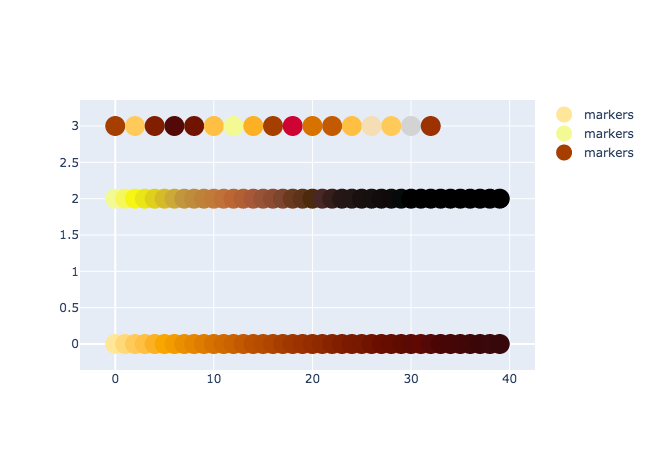

In [365]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(
    x=[i for i in range(40)], y=[0]*40,
    mode='markers',
    name='markers',
    marker_size=20,
    marker_color=colors_list,
    text=colors_list,
))
fig.add_trace(go.Scatter(
    x=[i for i in range(40)], y=[2]*40,
    mode='markers',
    name='markers',
    marker_size=20,
    marker_color=colors_list_2,
    text=colors_list_2,
))

fig.add_trace(go.Scatter(
    x=[2*i for i in range(17)], y=[3]*17,
    mode='markers',
    name='markers',
    marker_size=20,
    marker_color=list(map(beer_category_color, list_styles)),
    text=list_styles,
))



fig.show() 

# Data exploration

In [60]:
breweries_ch_RB_df

,name,link,location,brewer_typ,beer_count,established_year,brewer_id,img_link,address,telephone,website,latitude,longitude,ratings_avg
0,1386 Das Sempacher Bier,https://www.ratebeer.com/brewers/1386-das-semp...,Sempach,Microbrewery,2,2015,0,https://res.cloudinary.com/ratebeer/image/uplo...,"Weihermatte 5, Sempach, 6204, Switzerland",,http://www.1386.ch/,47.137141,8.193073,3.010
1,1936 Bière,https://www.ratebeer.com/brewers/1936-biere/14...,Verbier,Client Brewer,1,2012,1,https://res.cloudinary.com/ratebeer/image/uplo...,"Chemin des Luis 20, Verbier, 1936, Switzerland",44 7500001936,http://www.1936biere.com,46.104502,7.224338,2.650
2,3 Finger Joe,https://www.ratebeer.com/brewers/3-finger-joe/...,Sachseln,Microbrewery,3,2018,2,https://res.cloudinary.com/ratebeer/image/uplo...,"Haltenmatte 2, Sachseln, 6072, Switzerland",79 106 15 13,https://www.facebook.com/3-Finger-Joe-43032415...,46.868885,8.239202,3.020
3,4655 Brewing Company,https://www.ratebeer.com/brewers/4655-brewing-...,Stüsslingen,Microbrewery,5,2015,3,https://res.cloudinary.com/ratebeer/image/uplo...,"Stüsslingen, 4655, Switzerland",,//4655brew.co,47.392886,7.971289,3.088
4,7Peaks Brasserie,https://www.ratebeer.com/brewers/7peaks-brasse...,"Morgins, Vaud",Microbrewery,20,2014,4,https://res.cloudinary.com/ratebeer/image/uplo...,"Route de la Patinoire 15, Morgins, Switzerland",41 78 797 18 75,http://www.7peaksbrasserie.ch,46.237659,6.858102,3.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,zur Grünen Amsel,https://www.ratebeer.com/brewers/zur-grunen-am...,Riehen,Microbrewery,20,2010,571,https://res.cloudinary.com/ratebeer/image/uplo...,"Schmiedgasse 30, Riehen, 4125, Switzerland",79 534 30 10,http://www.s30.ch/,47.584695,7.651748,2.863
572,Zur Trotte,https://www.ratebeer.com/brewers/zur-trotte/11...,Berg am Irchel,Brewpub,1,2009,572,https://res.cloudinary.com/ratebeer/image/uplo...,"Dorfstrasse 2, Berg am Irchel, 8415, Switzerland",52 318 11 32,//www.zur-trotte.ch,47.569884,8.597786,2.770
573,Zurich Airport Beer (ZAB),https://www.ratebeer.com/brewers/zurich-airpor...,Zürich Flughafen,Client Brewer,2,2011,573,https://res.cloudinary.com/ratebeer/image/uplo...,"Operation Center 4, Zürich Flughafen, 8058, S...",43 8127948,http://www.flughafenbier.ch/,47.450295,8.562231,2.780
574,Zweierlei,https://www.ratebeer.com/brewers/zweierlei/29046/,Stans,Microbrewery,3,2016,574,https://res.cloudinary.com/ratebeer/image/uplo...,"Stans, 6370, Switzerland",,http://www.brauerei-zweierlei.ch/,46.957059,8.366129,2.880


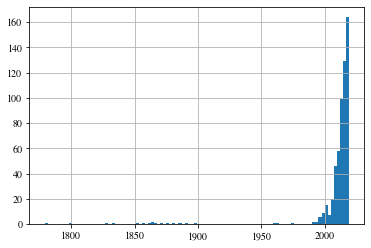

In [209]:
hist = breweries_ch_RB_df['established_year'].hist(bins=100)

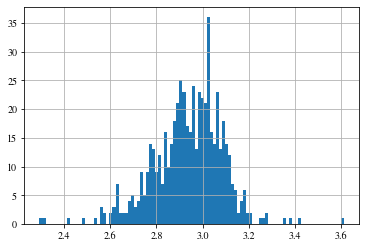

In [13]:
beers_rb_df.groupby('brewer_id')['ratings_avg'].mean().hist(bins=100)

In [15]:
breweries_ch_RB_df = breweries_ch_RB_df.merge(beers_rb_df.groupby('brewer_id')['ratings_avg'].mean(), on='brewer_id')

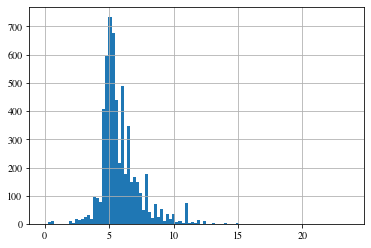

In [10]:
beers_rb_df['alcohol_perc'].hist(bins=100)